## Conditional GflowNets for mRNA sequences

In [1]:
from argparse import ArgumentParser
from typing import Tuple

import torch
from torch.optim import Adam
from tqdm import tqdm

from gfn.gflownet import (
    DBGFlowNet,
    FMGFlowNet,
    ModifiedDBGFlowNet,
    SubTBGFlowNet,
    TBGFlowNet,
)

from gfn.gym import HyperGrid

from gfn.modules import (
    ConditionalDiscretePolicyEstimator,
    ConditionalScalarEstimator,
    ScalarEstimator,
)
from gfn.utils.modules import MLP

DEFAULT_SEED: int = 4444

/tmp/ipykernel_900186/1006876251.py:18: DeprecationWarning: 'modules.py' is deprecated and will be removed in a future release. Please import from 'estimators.py' instead.
  from gfn.modules import (


In [2]:
def build_conditional_pf_pb(
    env: HyperGrid,
) -> Tuple[ConditionalDiscretePolicyEstimator, ConditionalDiscretePolicyEstimator]:

    """Build conditional policy forward and backward estimators.
    Args:
        env: The HyperGrid environment
    Returns:
        A tuple of (forward policy estimator, backward policy estimator)
    """

    CONCAT_SIZE = 16
    module_PF = MLP(
        input_dim=env.n_states,
        output_dim=CONCAT_SIZE,
        hidden_dim=256,
    )
    module_PB = MLP(
        input_dim=env.n_states,
        output_dim=CONCAT_SIZE,
        hidden_dim=256,
        trunk=module_PF.trunk,
    )

    # Encoder for the Conditioning information.
    module_cond = MLP(
        input_dim=1,
        output_dim=CONCAT_SIZE,
        hidden_dim=256,
    )

    # Modules post-concatenation.
    module_final_PF = MLP(
        input_dim=CONCAT_SIZE * 2,
        output_dim=env.n_actions,
    )
    module_final_PB = MLP(
        input_dim=CONCAT_SIZE * 2,
        output_dim=env.n_actions - 1,
        trunk=module_final_PF.trunk,
    )

    pf_estimator = ConditionalDiscretePolicyEstimator(
        module_PF,
        module_cond,
        module_final_PF,
        env.n_actions,
        is_backward=False,
    )
    pb_estimator = ConditionalDiscretePolicyEstimator(
        module_PB,
        module_cond,
        module_final_PB,
        env.n_actions,
        is_backward=True,
    )

    return pf_estimator, pb_estimator

In [3]:
def build_conditional_logF_scalar_estimator(
    env: HyperGrid,
) -> ConditionalScalarEstimator:
    """Build conditional log flow estimator.
    Args:
        env: The HyperGrid environment
    Returns:
        A conditional scalar estimator for log flow
    """
    CONCAT_SIZE = 16

    module_state_logF = MLP(
        input_dim=env.n_states,
        output_dim=CONCAT_SIZE,
        hidden_dim=256,
        n_hidden_layers=1,
    )
    module_conditioning_logF = MLP(
        input_dim=1,
        output_dim=CONCAT_SIZE,
        hidden_dim=256,
        n_hidden_layers=1,
    )
    module_final_logF = MLP(
        input_dim=CONCAT_SIZE * 2,
        output_dim=1,
        hidden_dim=256,
        n_hidden_layers=1,
    )

    logF_estimator = ConditionalScalarEstimator(
        module_state_logF,
        module_conditioning_logF,
        module_final_logF,
    )

    return logF_estimator

In [ ]:
# Build the GFlowNet -- Modules pre-concatenation.
def build_tb_gflownet(env: HyperGrid) -> TBGFlowNet:

    """Build a Trajectory Balance GFlowNet.
    Args:
        env: The HyperGrid environment
    Returns:
        A TBGFlowNet instance
    """
    pf_estimator, pb_estimator = build_conditional_pf_pb(env)

    module_logZ = MLP(
        input_dim=1,
        output_dim=1,
        hidden_dim=16,
        n_hidden_layers=2,
    )

    logZ_estimator = ScalarEstimator(module_logZ)
    gflownet = TBGFlowNet(logZ=logZ_estimator, pf=pf_estimator, pb=pb_estimator)

    return gflownet


In [9]:
def train(env, gflownet, seed=42):

    torch.manual_seed(seed)
    exploration_rate = 0.5
    lr = 0.0005

    # Policy parameters and logZ/logF get independent LRs (logF/Z typically higher).
    if type(gflownet) is TBGFlowNet:
        optimizer = Adam(gflownet.pf_pb_parameters(), lr=lr)
        optimizer.add_param_group({"params": gflownet.logz_parameters(), "lr": lr * 100})

    elif type(gflownet) is DBGFlowNet or type(gflownet) is SubTBGFlowNet:
        optimizer = Adam(gflownet.pf_pb_parameters(), lr=lr)
        optimizer.add_param_group({"params": gflownet.logF_parameters(), "lr": lr * 100})

    elif type(gflownet) is FMGFlowNet or type(gflownet) is ModifiedDBGFlowNet:
        optimizer = Adam(gflownet.parameters(), lr=lr)

    else:
        print("Unknown gflownet type: {}".format(type(gflownet)))

    n_iterations = int(10)  # 1e4)
    batch_size = int(1e4)

    print("+ Training Conditional {}!".format(type(gflownet)))

    for _ in (pbar := tqdm(range(n_iterations))):

        conditioning = torch.rand((batch_size, 1)).to(env.device)  # type: ignore
        conditioning = (conditioning > 0.5).to(torch.float)  # Randomly 1 and zero.

        trajectories = gflownet.sample_trajectories(
            env,
            n=batch_size,
            conditioning=conditioning,
            save_logprobs=False,
            save_estimator_outputs=True,
            epsilon=exploration_rate,
        )
        optimizer.zero_grad()
        loss = gflownet.loss_from_trajectories(
            env, trajectories, recalculate_all_logprobs=False
        )
        loss.backward()
        optimizer.step()
        pbar.set_postfix({"loss": loss.item()})

    print("+ Training complete!")

In [7]:
environment = HyperGrid(
        ndim=5,
        height=2
    )

/home/ubuntu/aya/GFN_for_mRNA_design/torchgfn/src/gfn/gym/hypergrid.py:93: UserWarning: + Warning: height <= 4 can lead to unsolvable environments.
  warnings.warn("+ Warning: height <= 4 can lead to unsolvable environments.")
/home/ubuntu/aya/GFN_for_mRNA_design/torchgfn/src/gfn/env.py:481: UserWarning: You're using advanced parameters: (sf). These are only needed for custom action handling. For basic environments, you can omit these.
  warnings.warn(


In [1]:
t = 'MMFPQSRHSGSSHLPQQLKFTTSDSCDRIKDEFQLLQAQYHSLKLECDKLASEKSEMQRHYVMYYEMSYGLNIEMHKQAEIVKRLNGICAQVLPYLSQEHQQQVLGAIERAKQVTAPELNSIIRQQLQAHQLSQLQALALPLTPLPVGLQPPSLPAVSAGTGLLSLSALGSQAHLSKEDKNGHDGDTHQEDDGEKSD*'

In [2]:
len(t)

198

In [3]:
s = 'MGASARLLRAVIMGAPGSGKGTVSSRITTHFELKHLSSGDLLRDNMLRGTEIGVLAKAFIDQGKLIPDDVMTRLALHELKNLTQYSWLLDGFPRTLPQAEALDRAYQIDTVINLNVPFEVIKQRLTARWIHPASGRVYNIEFNPPKTVGIDDLTGEPLIQREDDKPETVIKRLKAYEDQTKPVLEYYQKKGVLETFSGTETNKIWPYVYAFLQTKVPQRSQKASVTP*'

In [4]:
len(s)

228

In [5]:
def dna_to_mrna(dna: str) -> str:
    """Convert a DNA sequence to an mRNA sequence by replacing T with U."""
    dna = dna.upper().replace(" ", "")
    mrna = dna.replace('T', 'U')
    return mrna

In [6]:
dna = 'ATG GGG GCG TCC GCG CGG CTG CTG CGA GCG GTG ATC ATG GGG GCC CCG GGC TCG GGC AAG GGC ACC GTG TCG TCG CGC ATC ACT ACA CAC TTC GAG CTG AAG CAC CTC TCC AGC GGG GAC CTG CTC CGG GAC AAC ATG CTG CGG GGC ACA GAA ATT GGC GTG TTA GCC AAG GCT TTC ATT GAC CAA GGG AAA CTC ATC CCA GAT GAT GTC ATG ACT CGG CTG GCC CTT CAT GAG CTG AAA AAT CTC ACC CAG TAT AGC TGG CTG TTG GAT GGT TTT CCA AGG ACA CTT CCA CAG GCA GAA GCC CTA GAT AGA GCT TAT CAG ATC GAC ACA GTG ATT AAC CTG AAT GTG CCC TTT GAG GTC ATT AAA CAA CGC CTT ACT GCT CGC TGG ATT CAT CCC GCC AGT GGC CGA GTC TAT AAC ATT GAA TTC AAC CCT CCC AAA ACT GTG GGC ATT GAT GAC CTG ACT GGG GAG CCT CTC ATT CAG CGT GAG GAT GAT AAA CCA GAG ACG GTT ATC AAG AGA CTA AAG GCT TAT GAA GAC CAA ACA AAG CCA GTC CTG GAA TAT TAC CAG AAA AAA GGG GTG CTG GAA ACA TTC TCC GGA ACA GAA ACC AAC AAG ATT TGG CCC TAT GTA TAT GCT TTC CTA CAA ACT AAA GTT CCA CAA AGA AGC CAG AAA GCT TCA GTT ACT CCA TGA'

In [9]:
(dna_to_mrna(dna))

'AUGGGGGCGUCCGCGCGGCUGCUGCGAGCGGUGAUCAUGGGGGCCCCGGGCUCGGGCAAGGGCACCGUGUCGUCGCGCAUCACUACACACUUCGAGCUGAAGCACCUCUCCAGCGGGGACCUGCUCCGGGACAACAUGCUGCGGGGCACAGAAAUUGGCGUGUUAGCCAAGGCUUUCAUUGACCAAGGGAAACUCAUCCCAGAUGAUGUCAUGACUCGGCUGGCCCUUCAUGAGCUGAAAAAUCUCACCCAGUAUAGCUGGCUGUUGGAUGGUUUUCCAAGGACACUUCCACAGGCAGAAGCCCUAGAUAGAGCUUAUCAGAUCGACACAGUGAUUAACCUGAAUGUGCCCUUUGAGGUCAUUAAACAACGCCUUACUGCUCGCUGGAUUCAUCCCGCCAGUGGCCGAGUCUAUAACAUUGAAUUCAACCCUCCCAAAACUGUGGGCAUUGAUGACCUGACUGGGGAGCCUCUCAUUCAGCGUGAGGAUGAUAAACCAGAGACGGUUAUCAAGAGACUAAAGGCUUAUGAAGACCAAACAAAGCCAGUCCUGGAAUAUUACCAGAAAAAAGGGGUGCUGGAAACAUUCUCCGGAACAGAAACCAACAAGAUUUGGCCCUAUGUAUAUGCUUUCCUACAAACUAAAGUUCCACAAAGAAGCCAGAAAGCUUCAGUUACUCCAUGA'

In [10]:
f = "MCSLGLFPPPPPRGQVTLYEHNNELVTGSSYESPPPDFRGQWINLPVLQLTKDPLKTPGRLDHGTRTAFIHHREQVWKRCINIWRDVGLFGVLNEIANSEEEVFEWVKTASGWALALCRWASSLHGSLFPHLSLRSEDLIAEFAQVTNWSSCCLRVFAWHPHTNKFAVALLDDSVRVYNASSTIVPSLKHRLQRNVASLAWKPLSASVLAVACQSCILIWTLDPTSLSTRPSSGCAQVLSHPGHTPVTSLAWAPSGGRLLSASPVDAAIRVWDVSTETCVPLPWFRGGGVTNLLWSPDGSKILATTPSAVFRVWEAQMWTCERWPTLSGRCQTGCWSPDGSRLLFTVLGEPLIYSLSFPERCGEGKGCVGGAKSATIVADLSETTIQTPDGEERLGGEAHSMVWDPSGERLAVLMKGKPRVQDGKPVILLFRTRNSPVFELLPCGIIQGEPGAQPQLITFHPSFNKGALLSVGWSTGRIAHIPLYFVNAQFPRFSPVLGRAQEPPAGGGGSIHDLPLFTETSPTSAPWDPLPGPPPVLPHSPHSHL*"

In [11]:
len(f)

547

In [12]:
g = 'MDSEVQRDGRILDLIDDAWREDKLPYEDVAIPLNELPEPEQDNGGTTESVKEQEMKWTDLALQYLHENVPPIGN*'

In [13]:
len(g)

75

In [14]:
dna = 'ATG GAC AGT GAG GTT CAG AGA GAT GGA AGG ATC TTG GAT TTG ATT GAT GAT GCT TGG CGA GAA GAC AAG CTG CCT TAT GAG GAT GTC GCA ATA CCA CTG AAT GAG CTT CCT GAA CCT GAA CAA GAC AAT GGT GGC ACC ACA GAA TCT GTC AAA GAA CAA GAA ATG AAG TGG ACA GAC TTA GCC TTA CAG TAC CTC CAT GAG AAT GTT CCC CCC ATT GGA AAC TGA'

In [15]:
(dna_to_mrna(dna))

'AUGGACAGUGAGGUUCAGAGAGAUGGAAGGAUCUUGGAUUUGAUUGAUGAUGCUUGGCGAGAAGACAAGCUGCCUUAUGAGGAUGUCGCAAUACCACUGAAUGAGCUUCCUGAACCUGAACAAGACAAUGGUGGCACCACAGAAUCUGUCAAAGAACAAGAAAUGAAGUGGACAGACUUAGCCUUACAGUACCUCCAUGAGAAUGUUCCCCCCAUUGGAAACUGA'

In [16]:
s = 'MTSMTQSLREVIKAMTKARNFERVLGKITLVSAAPGKVICEMKVEEEHTNAIGTLHGGLTATLVDNISTMALLCTERGAPGVSVDMNITYMSPAKLGEDIVITAHVLKQGKTLAFTSVDLTNKATGKLIAQGRHTKHLGN*'

In [17]:
len(s)

141

In [19]:
torch.rand([4,2,3])

tensor([[[0.0298, 0.5758, 0.0476],
         [0.6708, 0.9973, 0.1954]],

        [[0.2637, 0.2925, 0.6079],
         [0.3303, 0.6801, 0.6996]],

        [[0.3959, 0.9561, 0.7664],
         [0.2526, 0.2801, 0.9920]],

        [[0.8828, 0.9636, 0.6264],
         [0.6238, 0.4503, 0.5629]]])

In [2]:
weights = torch.rand(3)

In [4]:
conditioning = torch.rand(3)
conditioning = conditioning.unsqueeze(0).expand(2, *conditioning.shape)

In [5]:
conditioning.shape

torch.Size([2, 3])

In [17]:
conditioning = torch.rand(3)
conditioning = conditioning.unsqueeze(0).expand(2, *conditioning.shape)
conditioning = conditioning.expand((141+2,) + conditioning.shape)

In [18]:
conditioning.shape

torch.Size([143, 2, 3])

In [ ]:
conditioning = conditioning.expand((143,) + conditioning.shape)

In [10]:
conditioning.shape

torch.Size([143, 2, 3])

In [ ]:
conditioning = conditioning.expand((2,) + conditioning.shape)

RuntimeError: The expanded size of the tensor (100) must match the existing size (2) at non-singleton dimension 1.  Target sizes: [2, 100, 3].  Tensor sizes: [2, 3]

In [29]:
conditioning.shape

torch.Size([2, 100, 2, 3])

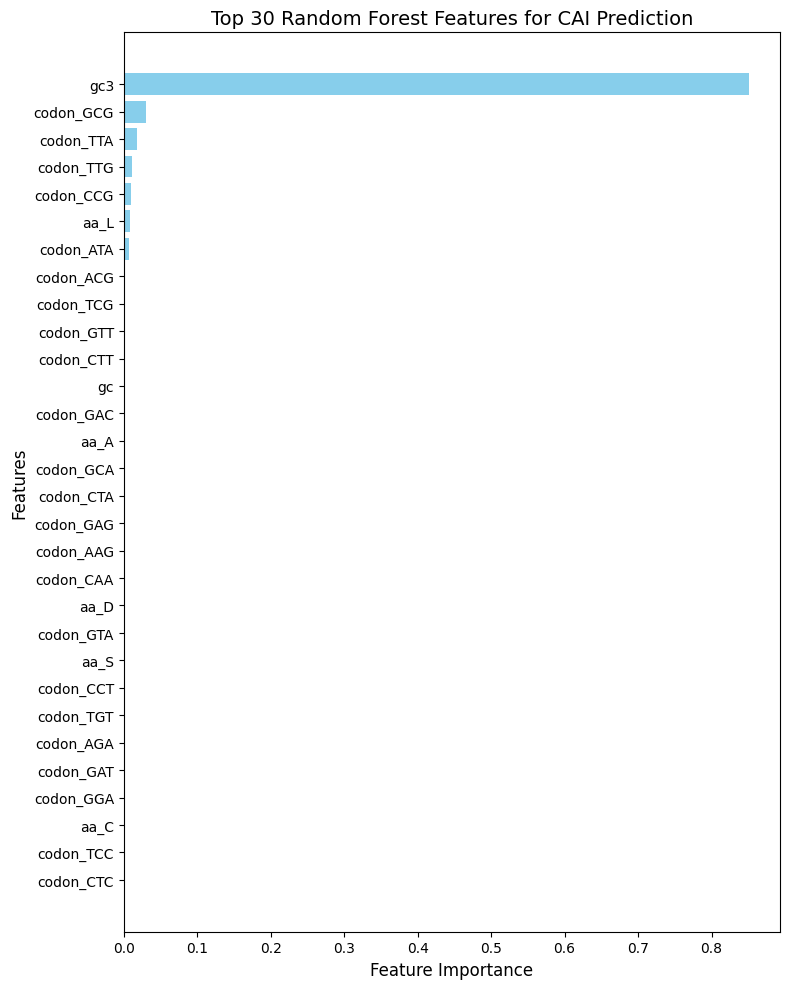

In [1]:
import matplotlib.pyplot as plt

feature_importances = {
    "gc3": 0.8507,
    "codon_GCG": 0.0298,
    "codon_TTA": 0.0185,
    "codon_TTG": 0.0115,
    "codon_CCG": 0.0096,
    "aa_L": 0.0082,
    "codon_ATA": 0.0077,
    "codon_ACG": 0.0019,
    "codon_TCG": 0.0019,
    "codon_GTT": 0.0018,
    "codon_CTT": 0.0017,
    "gc": 0.0015,
    "codon_GAC": 0.0015,
    "aa_A": 0.0014,
    "codon_GCA": 0.0014,
    "codon_CTA": 0.0013,
    "codon_GAG": 0.0013,
    "codon_AAG": 0.0013,
    "codon_CAA": 0.0012,
    "aa_D": 0.0012,
    "codon_GTA": 0.0011,
    "aa_S": 0.0010,
    "codon_CCT": 0.0010,
    "codon_TGT": 0.0010,
    "codon_AGA": 0.0010,
    "codon_GAT": 0.0009,
    "codon_GGA": 0.0009,
    "aa_C": 0.0009,
    "codon_TCC": 0.0009,
    "codon_CTC": 0.0009
}

features = list(feature_importances.keys())
importances = list(feature_importances.values())

sorted_idx = sorted(range(len(importances)), key=lambda i: importances[i], reverse=True)
sorted_features = [features[i] for i in sorted_idx]
sorted_importances = [importances[i] for i in sorted_idx]

plt.figure(figsize=(8, 10))
plt.barh(sorted_features, sorted_importances, color="skyblue")
plt.xlabel("Feature Importance", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.title("Top 30 Random Forest Features for CAI Prediction", fontsize=14)
plt.gca().invert_yaxis()  # Highest importance at top
plt.tight_layout()
plt.show()
